In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer


In [2]:
texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']


In [3]:
tk=Tokenizer()
tk.fit_on_texts(texts)


In [4]:
tk.word_index

{'바나나': 1,
 '먹고': 2,
 '싶은': 3,
 '사과': 4,
 '길고': 5,
 '노란': 6,
 '저는': 7,
 '과일이': 8,
 '좋아요': 9}

In [10]:
tk.texts_to_matrix(texts, mode='count') # 단어를 카운트하는것 
tk.texts_to_matrix(texts, mode='binary') # 단어 여부 확인


array([[0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])

## 뉴스 데이터로 모델링하기

In [11]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


In [14]:
df=fetch_20newsgroups(subset='train')

In [15]:
df.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [17]:
len(df.data)

11314

In [26]:
df.target_names
# 20개의 주제가있다. 

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [31]:
# print(df.data[7])
df.target_names[7]

'rec.autos'

In [36]:
data=pd.DataFrame(data=df.data,columns=['email'])

In [41]:
data['target']=df.target

In [42]:
data.head()

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


<Axes: xlabel='target'>

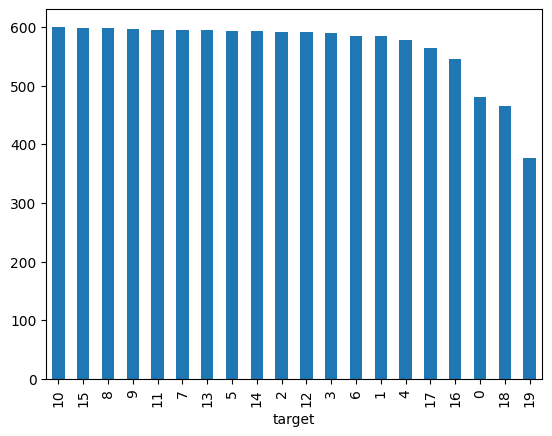

In [46]:
data['target'].value_counts().plot(kind='bar')

In [49]:
data[['target']].value_counts()

target
10        600
15        599
8         598
9         597
11        595
7         594
13        594
5         593
14        593
12        591
2         591
3         590
6         585
1         584
4         578
17        564
16        546
0         480
18        465
19        377
Name: count, dtype: int64

In [50]:
test=fetch_20newsgroups(subset='test',shuffle=True)
train_X= data['email']
train_y=data['target']
test_X= test.data
test_y=test.target

In [53]:
vocab_size=10000
class_num=20



In [54]:
def prepare_data(train_data, test_data, mode): # 전처리 함수
    tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용한다.
    tokenizer.fit_on_texts(train_data)
    X_train = tokenizer.texts_to_matrix(train_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    X_test = tokenizer.texts_to_matrix(test_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    return X_train, X_test, tokenizer.index_word


In [55]:
X_train, X_test, index_to_word = prepare_data(train_X, test_X, 'binary') # binary 모드로 변환

In [56]:
# 원 핫 인코딩 
y_train= to_categorical(train_y,class_num)
y_test= to_categorical(test_y,class_num)


In [59]:
X_train[0] # binary로 변환하였기 때문에 차원이 매우 크다. 

array([0., 1., 1., ..., 0., 0., 0.])

In [61]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [63]:
index_to_word[9999]

'mic'

## MLP 사용

In [69]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Input


In [80]:
def fit_and_evaluate(X_train, y_train,X_test, y_test):
    inputs=Input(shape=(vocab_size,))
    x= Dropout(0.5)(inputs)
    x=Dense(128, activation='relu')(x)
    x= Dropout(0.5)(x)
    x= Dense(class_num, activation='softmax')(x)
    model=Model(inputs=inputs, outputs=x)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    model.fit(X_train,y_train, batch_size=128, epochs=5, verbose=1
              ,validation_split=0.1)
    score=model.evaluate(X_test,y_test,batch_size=128, verbose=2)
    return score

    


In [81]:
modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.

for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
    X_train, X_test, _ = prepare_data(train_X, test_X, mode) # 모드에 따라서 데이터를 전처리
    score = fit_and_evaluate(X_train, y_train, X_test, y_test) # 모델을 훈련하고 평가.
    print(mode+' 모드의 테스트 정확도:', score)


Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2306 - loss: 2.6554 - val_accuracy: 0.8269 - val_loss: 1.1830
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7129 - loss: 1.1934 - val_accuracy: 0.8719 - val_loss: 0.6810
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8097 - loss: 0.7657 - val_accuracy: 0.9011 - val_loss: 0.5138
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8587 - loss: 0.5812 - val_accuracy: 0.8975 - val_loss: 0.4374
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8864 - loss: 0.4660 - val_accuracy: 0.9081 - val_loss: 0.3875
59/59 - 0s - 2ms/step - accuracy: 0.8322 - loss: 0.6623
binary 모드의 테스트 정확도: [0.6623156666755676, 0.8321827054023743]
Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1833 - loss: 3.0678 - val_accuracy: 0.7906 - val_loss: 1.4166
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6462 - loss: 1.4898 - val_accuracy: 0.8507 - val_loss: 0.8361
Ep